## Read depth model
Modeled as zero inflated negative binomial distribution

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.stats import nbinom
from scipy.stats import betabinom
import numpy as np
from scipy.special import logsumexp
from collections import Counter

In [157]:
sample = "mm34"

reference = pd.read_csv(rf'../data/input_data/{sample}/ref.csv', index_col=0)
alternative = pd.read_csv(rf'../data/input_data/{sample}/alt.csv', index_col=0)
coverage = reference.fillna(0) + alternative.fillna(0)
vaf = alternative/(alternative+reference).fillna(0)

In [158]:
def sample_zinb(mu, theta, pi, size):
    """
    Samples synthetic data from the learned ZINB distribution.
    
    Args:
        mu: Mean of the Negative Binomial.
        theta: Dispersion parameter of the Negative Binomial.
        pi: Zero-inflation probability.
        size: Number of samples to generate.
    
    Returns:
        A numpy array of sampled data.
    """
    nb_samples = nbinom.rvs(theta, theta / (theta+ mu), size=size)
    zero_inflation_mask = np.random.rand(size) < pi
    samples = np.where(zero_inflation_mask, 0, nb_samples)
    return samples

# learned from mm34 scRNA seq dataset
mu, theta, pi = 60, 0.17, 0.38
synthetic_data = sample_zinb(mu, theta, pi, size=10000)

We have to deal with a very large proportion of zero read depths

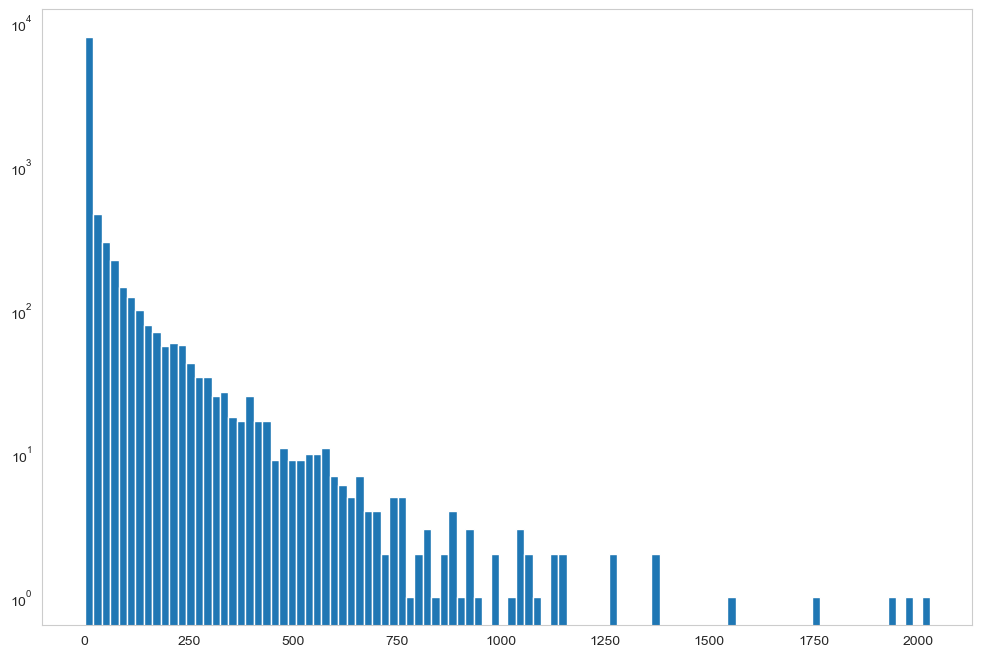

In [159]:
plt.figure(figsize=(12, 8))
plt.hist(synthetic_data, bins=100)
plt.yscale('log')
plt.grid(False)
plt.show()

## VAF simulation

1. Homozygous alternative genotype
2. Homozygous reference genotype
3. Heterozygous genotype

1. Homozygous reference genotype

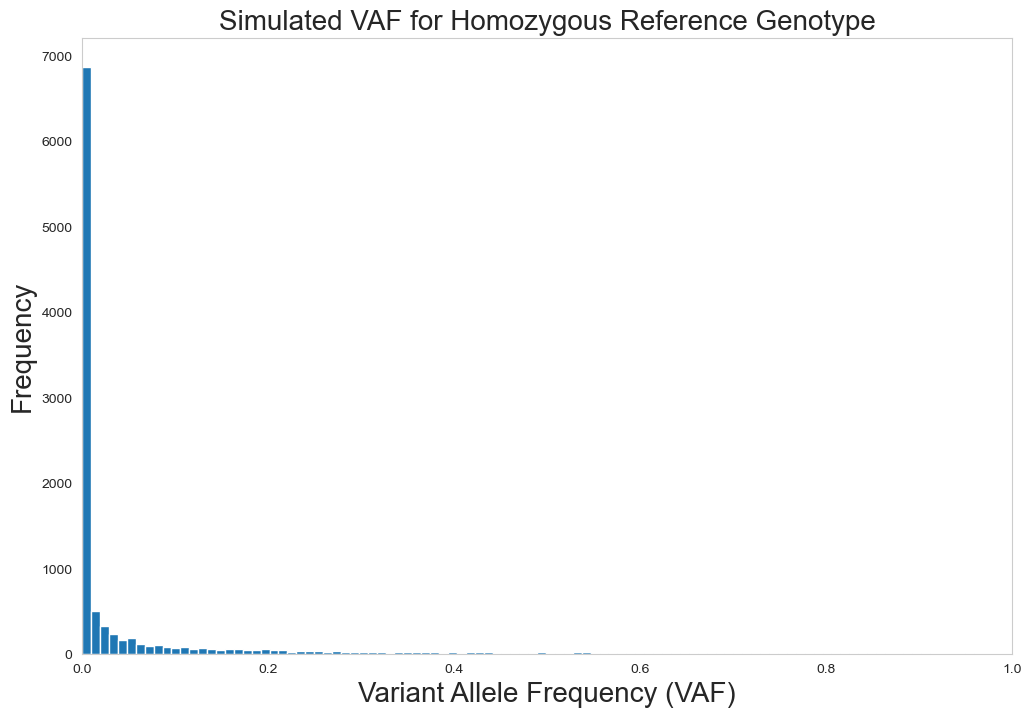

In [160]:
N = 1000  # Read depth
overdispersion = 2 # Should be learned
error_rate = 0.05  # Sequencing error rate (learned?)
alpha = error_rate * overdispersion
beta = overdispersion - alpha

# Generate simulated data for VAF using Beta-Binomial
simulated_vaf = betabinom.rvs(N, alpha, beta, size=10000) / N  # Scale by N to get VAFs

plt.figure(figsize=(12, 8))
plt.hist(simulated_vaf, bins=100)
plt.title("Simulated VAF for Homozygous Reference Genotype", fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xlim([0, 1])
plt.grid(False)
plt.show()

2. Homozygous alternative genotype

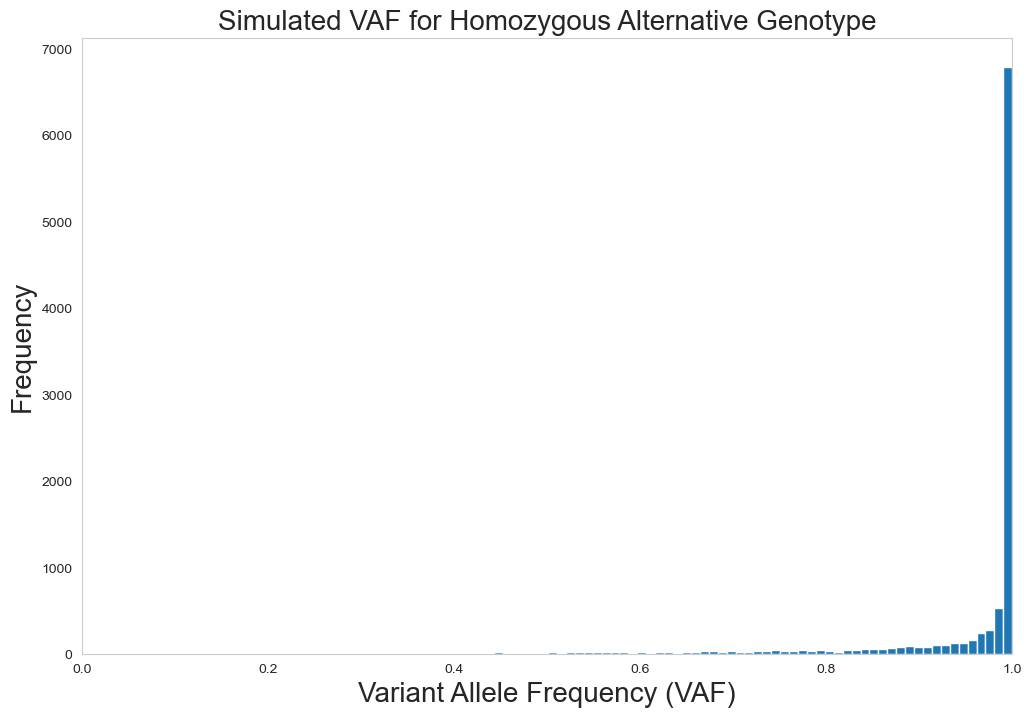

In [161]:
N = 1000  # Read depth
overdispersion = 2 # Should be learned
error_rate = 0.05  # Sequencing error rate (learned?)
alpha = (1-error_rate) * overdispersion
beta = overdispersion - alpha

# Generate simulated data for VAF using Beta-Binomial
simulated_vaf = betabinom.rvs(N, alpha, beta, size=10000) / N  # Scale by N to get VAFs

plt.figure(figsize=(12, 8))
plt.hist(simulated_vaf, bins=100)
plt.title("Simulated VAF for Homozygous Alternative Genotype", fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xlim([0, 1])
plt.grid(False)
plt.show()

3. Heterozygous genotype

Technical dropout

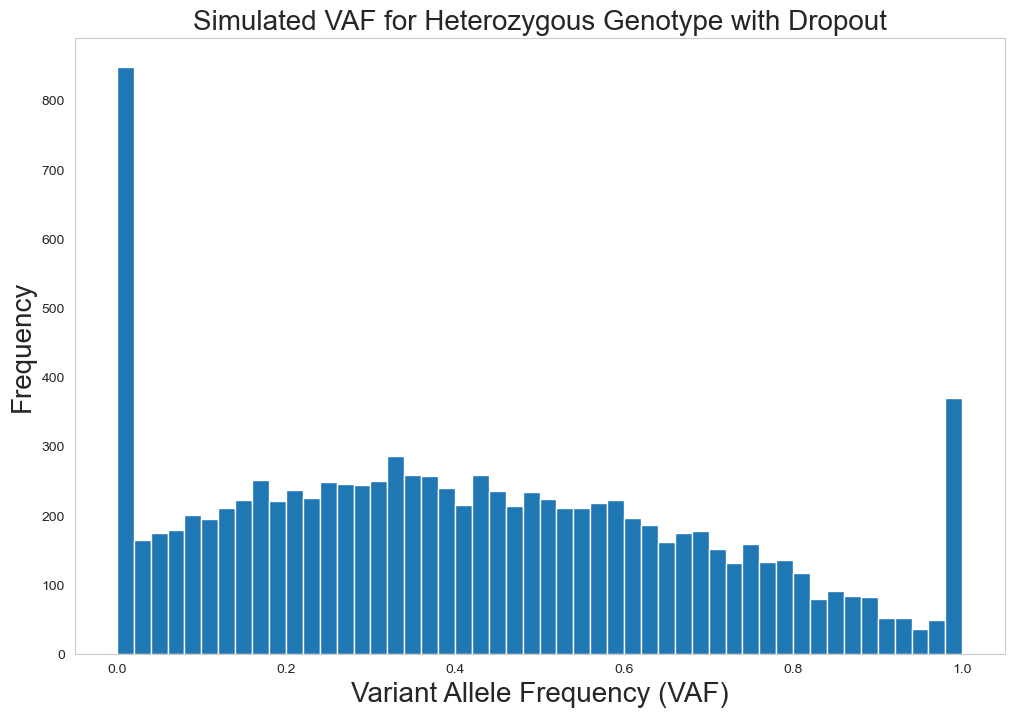

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import betabinom, bernoulli

def simulate_vaf_counts(alpha, beta, dropout_prob, dropout_direction_prob, N, num_simulations, error_rate, overdispersion):
    """
    Simulates VAF counts for a heterozygous genotype considering dropout and overdispersion.
    
    Parameters:
    - alpha: Shape parameter of the Beta distribution.
    - beta: Shape parameter of the Beta distribution.
    - dropout_prob: Probability of a technical dropout.
    - dropout_direction_prob: Probability the dropout favors the reference allele.
    - N: Read depth
    - num_simulations: Number of VAF simulations.
    - error_rate: Error rate for monoallelic expressed genes
    - overdispersion: Overdispersion parameter for monoallelic expressed genes
    
    
    Returns:
    - vaf_counts: Array of simulated VAF counts (variant reads).
    """
    vaf_counts = []
    
    for _ in range(num_simulations):
        # Check if a dropout occurs
        is_dropout = bernoulli.rvs(dropout_prob)
        
        if is_dropout:
            # Sample dropout direction (reference or alternative allele)
            dropout_direction = bernoulli.rvs(dropout_direction_prob)
            
            # If dropout favors reference, all reads are reference (0 alt reads)
            # If dropout favors alternative, all reads are alternative (N alt reads)
            if dropout_direction == 1:
                alpha_seq = error_rate * overdispersion
                beta_seq = overdispersion - alpha_seq
                alt_reads = betabinom.rvs(N, alpha_seq, beta_seq)
                # alt_reads = 0
            else:
                alpha_seq = (1-error_rate) * overdispersion
                beta_seq = overdispersion - alpha_seq
                alt_reads = betabinom.rvs(N, alpha_seq, beta_seq)
                # alt_reads = N
        
        else:
            # No dropout: use Beta-Binomial distribution to simulate alt reads
            alt_reads = betabinom.rvs(N, alpha, beta)
        
        vaf_counts.append(alt_reads) 
         
    vaf_counts = np.array(vaf_counts)/N
    
    return vaf_counts

# Parameters
alpha = 1.5               # Beta distribution alpha parameter
beta = 2                # Beta distribution beta parameter
dropout_prob = 0.15      # Probability of a technical dropout
dropout_direction_prob = 0.7  # Probability dropout favors reference allele
error_rate = 0.05       # Sequencing error rate
overdispersion = 2      # Overdispersion of sequencing errors.
N = 300                 # Read depth
num_simulations = 10000 # Number of simulations

# Simulate VAF counts
vaf_counts = simulate_vaf_counts(alpha, beta, dropout_prob, dropout_direction_prob, N, num_simulations, error_rate, overdispersion)

plt.figure(figsize=(12, 8))
plt.hist(vaf_counts, bins=50)
plt.title("Simulated VAF for Heterozygous Genotype with Dropout",  fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.grid(False)

plt.show()

Ground Truth Parameters:
f_AA: 0.6000, f_Aa: 0.3000, f_aa: 0.1000
Simulated Read Counts: Counter({'AA': 599, 'Aa': 305, 'aa': 96})

Estimated Parameters:
f_AA: 0.6008, f_Aa: 0.3044, f_aa: 0.0948
Observed Read Counts: Counter({0: 562, 1: 356, 2: 82})


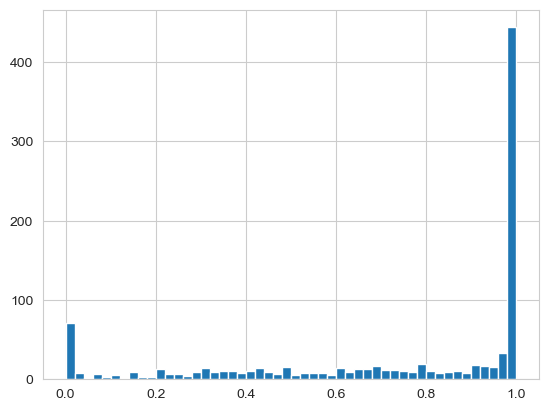

In [173]:
def beta_binomial_params(overdispersion, error_rate, genotype):
    """
    Computes the Beta-Binomial parameters for a given genotype.
    """
    if genotype == "AA":  # Homozygous reference
        alpha = (1 - error_rate) * overdispersion
        beta = overdispersion - alpha
    elif genotype == "aa":  # Homozygous alternative
        alpha = error_rate * overdispersion
        beta = overdispersion - alpha
    return alpha, beta

def genotype_probability(k, N, overdispersion, error_rate, genotype, alpha_h, beta_h):
    """
    Computes the probability of observing `k` alternative reads given genotype.
    """
    if genotype == "Aa":
        alpha, beta = alpha_h, beta_h
    else:
        alpha, beta = beta_binomial_params(overdispersion, error_rate, genotype)
    return betabinom.pmf(k, N, alpha, beta)

def e_step(k_obs, N, f_AA, f_Aa, f_aa, overdispersion, error_rate, alpha_h, beta_h):
    """
    E-Step: Computes the responsibilities for each genotype given observations.
    """
    responsibilities = []
    for k, n in zip(k_obs, N):
        # Compute unnormalized posterior probabilities for each genotype
        log_p_AA = np.log(f_AA) + np.log(genotype_probability(k, n, overdispersion, error_rate, "AA", alpha_h, beta_h))
        log_p_Aa = np.log(f_Aa) + np.log(genotype_probability(k, n, overdispersion, error_rate, "Aa", alpha_h, beta_h))
        log_p_aa = np.log(f_aa) + np.log(genotype_probability(k, n, overdispersion, error_rate, "aa", alpha_h, beta_h))
        
        # Use log-sum-exp trick for numerical stability
        log_total = logsumexp([log_p_AA, log_p_Aa, log_p_aa])
        
        # Compute responsibilities
        resp_AA = np.exp(log_p_AA - log_total)
        resp_Aa = np.exp(log_p_Aa - log_total)
        resp_aa = np.exp(log_p_aa - log_total)
        
        responsibilities.append([resp_AA, resp_Aa, resp_aa])
    
    return np.array(responsibilities)

def m_step(responsibilities):
    """
    M-Step: Updates genotype frequencies based on responsibilities.
    """
    f_AA = np.mean(responsibilities[:, 0])
    f_Aa = np.mean(responsibilities[:, 1])
    f_aa = np.mean(responsibilities[:, 2])
    return f_AA, f_Aa, f_aa

def em_algorithm_fixed_params(k_obs, N, f_AA_init, f_Aa_init, f_aa_init, overdispersion, error_rate, alpha_h, beta_h, min_iterations=10, max_iterations=100, tolerance=1e-6):
    """
    Runs the EM algorithm to estimate genotype proportions with fixed parameters.
    """
    f_AA, f_Aa, f_aa = f_AA_init, f_Aa_init, f_aa_init
    prev_log_likelihood = None
    
    for iteration in range(max_iterations):
        # E-Step
        responsibilities = e_step(k_obs, N, f_AA, f_Aa, f_aa, overdispersion, error_rate, alpha_h, beta_h)
        
        # M-Step
        f_AA, f_Aa, f_aa = m_step(responsibilities)
        
        # Compute log-likelihood for convergence check
        log_likelihood = 0
        for k, n, resp in zip(k_obs, N, responsibilities):
            log_p_AA = np.log(f_AA) + np.log(genotype_probability(k, n, overdispersion, error_rate, "AA", alpha_h, beta_h))
            log_p_Aa = np.log(f_Aa) + np.log(genotype_probability(k, n, overdispersion, error_rate, "Aa", alpha_h, beta_h))
            log_p_aa = np.log(f_aa) + np.log(genotype_probability(k, n, overdispersion, error_rate, "aa", alpha_h, beta_h))
            log_total = logsumexp([log_p_AA, log_p_Aa, log_p_aa])
            log_likelihood += log_total
        
        # Check convergence
        if iteration >= min_iterations:  # Only check convergence after min_iterations
            if prev_log_likelihood is not None and abs(log_likelihood - prev_log_likelihood) < tolerance:
                break
        
        prev_log_likelihood = log_likelihood
    
    return f_AA, f_Aa, f_aa, responsibilities

# Parameters
np.random.seed(42)
num_simulations = 1000
overdispersion = 2
error_rate = 0.05
alpha_h, beta_h = 2, 2  # Heterozygous Beta-Binomial parameters
f_AA_true, f_Aa_true, f_aa_true = 0.6, 0.3, 0.1

# Simulate varying read depths
N = np.random.randint(500, 1500, size=num_simulations)  # Variable read depths

# Generate simulated data
genotypes = np.random.choice(["AA", "Aa", "aa"], size=num_simulations, p=[f_AA_true, f_Aa_true, f_aa_true])
k_obs = []
read_counts = Counter(genotypes)
for genotype, n in zip(genotypes, N):
    if genotype == "Aa":
        alpha, beta = alpha_h, beta_h
    else:
        alpha, beta = beta_binomial_params(overdispersion, error_rate, genotype)
    k_obs.append(betabinom.rvs(n, alpha, beta))

# Run EM algorithm with fixed parameters
f_AA_init, f_Aa_init, f_aa_init = 1/3, 1/3, 1/3
f_AA_est, f_Aa_est, f_aa_est, responsibilities = em_algorithm_fixed_params(
    k_obs, N, f_AA_init, f_Aa_init, f_aa_init, overdispersion, error_rate, alpha_h, beta_h
)

# Observed read counts
observed_counts = Counter(np.argmax(responsibilities, axis=1))
total_simulations = sum(observed_counts.values())

# Results
print("Ground Truth Parameters:")
print(f"f_AA: {f_AA_true:.4f}, f_Aa: {f_Aa_true:.4f}, f_aa: {f_aa_true:.4f}")
print(f"Simulated Read Counts: {read_counts}")
print("\nEstimated Parameters:")
print(f"f_AA: {f_AA_est:.4f}, f_Aa: {f_Aa_est:.4f}, f_aa: {f_aa_est:.4f}")
print(f"Observed Read Counts: {observed_counts}")

plt.hist(k_obs/N, bins=50)
plt.show()

f_AA: 0.5084, f_Aa: 0.1861, f_aa: 0.3055


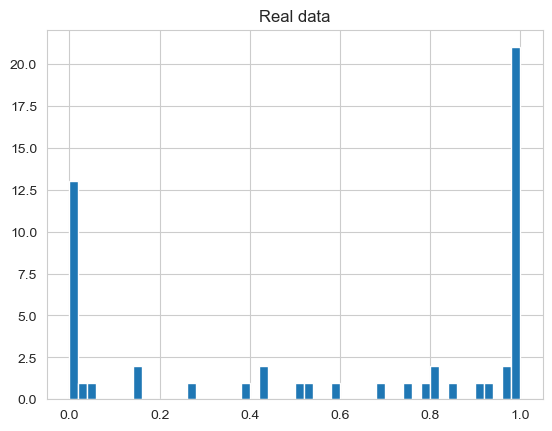

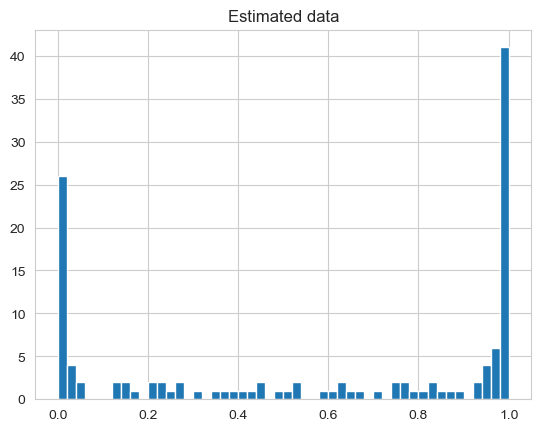

In [174]:
f_AA_init, f_Aa_init, f_aa_init = 1/3, 1/3, 1/3

non_zero_indices = np.where(coverage.iloc[:, 0] > 0)[0]
N_nonzero = np.array(coverage)[:, 0][non_zero_indices]
k_obs_nonzero = np.array(alternative)[:, 0][non_zero_indices]

f_AA_est, f_Aa_est, f_aa_est, responsibilities = em_algorithm_fixed_params(
    k_obs_nonzero, N_nonzero, f_AA_init, f_Aa_init, f_aa_init, overdispersion, error_rate, alpha_h, beta_h
)
print(f"f_AA: {f_AA_est:.4f}, f_Aa: {f_Aa_est:.4f}, f_aa: {f_aa_est:.4f}")

n_cells = 127
N = np.random.randint(500, 1500, size=n_cells)  # Variable read depths

# Generate simulated data
genotypes = np.random.choice(["AA", "Aa", "aa"], size=n_cells, p=[f_AA_est, f_Aa_est, f_aa_est])
k_obs = []
read_counts = Counter(genotypes)
for genotype, n in zip(genotypes, N):
    if genotype == "Aa":
        alpha, beta = alpha_h, beta_h
    else:
        alpha, beta = beta_binomial_params(overdispersion, error_rate, genotype)
    k_obs.append(betabinom.rvs(n, alpha, beta))
    
plt.hist(vaf.iloc[:, 0], bins=50)
plt.title("Real data")
plt.show()

plt.hist(k_obs/N, bins=50)
plt.title("Estimated data")
plt.show()

In [235]:
import numpy as np
from scipy.special import gammaln, logsumexp
from scipy.optimize import minimize_scalar

# Log likelihood for Beta-Binomial
def beta_binomial_log_likelihood(k, n, alpha, beta):
    """
    Computes the log-likelihood for a single Beta-Binomial observation.
    """
    log_coeff = gammaln(n + 1) - gammaln(k + 1) - gammaln(n - k + 1)
    log_beta = gammaln(alpha + k) + gammaln(beta + n - k) - gammaln(alpha + beta + n)
    log_beta_norm = gammaln(alpha) + gammaln(beta) - gammaln(alpha + beta)
    return log_coeff + log_beta - log_beta_norm

In [291]:
np.random.seed(42)

# Log likelihood for all observations
def total_log_likelihood(params, k_obs, N_obs, genotypes):
    """
    Computes the total log-likelihood for the given parameters and observations.
    """
    dropout_prob, dropout_direction_prob, overdispersion, error_rate, alpha_h, beta_h = params
    log_likelihood = 0

    for k, n, genotype in zip(k_obs, N_obs, genotypes):
        if genotype == "AA":
            # Homozygous dominant: no dropout
            alpha = (1 - error_rate) * overdispersion
            beta = overdispersion - alpha
            log_likelihood += beta_binomial_log_likelihood(k, n, alpha, beta)

        elif genotype == "Aa":
            # Heterozygous: apply dropout
        
            # No dropout likelihood
            log_no_dropout = np.log(1 - dropout_prob) + beta_binomial_log_likelihood(k, n, alpha_h, beta_h)
        
            # Dropout to "AA"
            alpha_AA = (1 - error_rate) * overdispersion
            beta_AA = overdispersion - alpha_AA
            log_dropout_AA = np.log(dropout_prob) + np.log(1 - dropout_direction_prob) + \
                beta_binomial_log_likelihood(k, n, alpha_AA, beta_AA)
        
            # Dropout to "aa"
            alpha_aa = error_rate * overdispersion
            beta_aa = overdispersion - alpha_aa
            log_dropout_aa = np.log(dropout_prob) + np.log(dropout_direction_prob) + \
                beta_binomial_log_likelihood(k, n, alpha_aa, beta_aa)
        
            # Combine probabilities
            log_likelihood += logsumexp([log_no_dropout, log_dropout_AA, log_dropout_aa])
            
        elif genotype == "aa":
            # Homozygous recessive: no dropout
            alpha = error_rate * overdispersion
            beta = overdispersion - alpha
            log_likelihood += beta_binomial_log_likelihood(k, n, alpha, beta)

        else:
            raise ValueError(f"Unexpected genotype: {genotype}")


    return -log_likelihood  # Negative because we're minimizing


def fit_parameters_coord_descent_damped(k_obs, N_obs, genotypes, 
                                        initial_params=None, 
                                        max_iterations=1000, 
                                        tolerance=1e-5, 
                                        damping_factor=0.5):
    """
    Fit dropout probability, dropout direction probability, overdispersion, error rate,
    and heterozygous-specific alpha and beta using coordinate descent with damping.
    """
    def optimize_param(param_idx, params, k_obs, N_obs, genotypes):
        """Optimize a single parameter while keeping others fixed."""
        def objective(param_value):
            new_params = params.copy()
            new_params[param_idx] = param_value
            return total_log_likelihood(new_params, k_obs, N_obs, genotypes)
        
        bounds = [
            (0.01, 0.99),    # dropout_prob
            (0.01, 0.99),   # dropout_direction_prob
            (0.1, 100),      # overdispersion
            (0.001, 0.1),   # error_rate
            (0.1, 50),       # alpha_h for heterozygous
            (0.1, 50)        # beta_h for heterozygous
        ]
        result = minimize_scalar(objective, bounds=bounds[param_idx], method="bounded")
        if result.success:
            return result.x
        else:
            raise RuntimeError(f"Optimization failed for parameter {param_idx}")
    
    # Initialization
    if initial_params is None:
        initial_params = [0.1, 0.5, 5, 0.01, 2, 2]  # Include alpha_h and beta_h
    params = np.array(initial_params)
    param_names = ["dropout_prob", "dropout_direction_prob", "overdispersion", "error_rate", "alpha_h", "beta_h"]
    
    prev_log_likelihood = None
    for iteration in range(max_iterations):
        prev_params = params.copy()
        for param_idx, param_name in enumerate(param_names):
            # if param_name == "dropout_direction_prob":
            #     continue
            # Optimize one parameter at a time
            optimized_param = optimize_param(param_idx, params, k_obs, N_obs, genotypes)
            # print(param_name, optimized_param)
            # Apply damped update to parameter
            params[param_idx] = (1 - damping_factor) * params[param_idx] + damping_factor * optimized_param
        
        # Check convergence
        log_likelihood = -total_log_likelihood(params, k_obs, N_obs, genotypes)
        print(f"Iteration {iteration + 1}, Log Likelihood: {log_likelihood}")
        if prev_log_likelihood is not None and abs(log_likelihood - prev_log_likelihood) < tolerance:
            print(f"Converged after {iteration + 1} iterations")
            break
        prev_log_likelihood = log_likelihood

        # Check if parameters are changing significantly
        max_change = np.max(np.abs(params - prev_params))
        if max_change < tolerance:
            print(f"Parameters stabilized after {iteration + 1} iterations")
            break
    else:
        print("Reached max iterations without convergence")
    
    return params

vafs = k_obs_nonzero/N_nonzero
genotypes = [
    "AA" if (a != 1 and a > 0.5 and np.random.random() < 0.1) else
    "Aa" if a != 1 else
    "AA" if np.random.random() > 0.5 else
    "Aa"
    for a in vafs
]

fitted_params = fit_parameters_coord_descent_damped(
    k_obs_nonzero, 
    N_nonzero, 
    genotypes, 
    initial_params=[0.2, 0.5, 5, 0.01, 2, 2], 
    max_iterations=50, 
    tolerance=1e-5, 
    damping_factor=0.1  # Slower updates for stability
)

dropout_prob, dropout_direction_prob, overdispersion, error_rate, alpha_h, beta_h = fitted_params

print("Fitted Parameters:")
print(f"Dropout Probability: {dropout_prob}")
print(f"Dropout Direction Probability: {dropout_direction_prob}")
print(f"Overdispersion: {overdispersion}")
print(f"Error Rate: {error_rate}")
print(f"Heterozygous Alpha (alpha_h): {alpha_h}")
print(f"Heterozygous Beta (beta_h): {beta_h}")

Iteration 1, Log Likelihood: -168.74365512507194
Iteration 2, Log Likelihood: -164.6337120060587
Iteration 3, Log Likelihood: -161.62881463310148
Iteration 4, Log Likelihood: -159.3890941691399
Iteration 5, Log Likelihood: -157.70474155951064
Iteration 6, Log Likelihood: -156.4308635843521
Iteration 7, Log Likelihood: -155.46155570107146
Iteration 8, Log Likelihood: -154.717732443953
Iteration 9, Log Likelihood: -154.14132265231308
Iteration 10, Log Likelihood: -153.69051305605112
Iteration 11, Log Likelihood: -153.33518735838652
Iteration 12, Log Likelihood: -153.05334687595945
Iteration 13, Log Likelihood: -152.82865285985056
Iteration 14, Log Likelihood: -152.64877714973
Iteration 15, Log Likelihood: -152.50429072117146
Iteration 16, Log Likelihood: -152.38789980091377
Iteration 17, Log Likelihood: -152.29390992957573
Iteration 18, Log Likelihood: -152.21784187396344
Iteration 19, Log Likelihood: -152.15615114856814
Iteration 20, Log Likelihood: -152.10601952722115
Iteration 21, Log

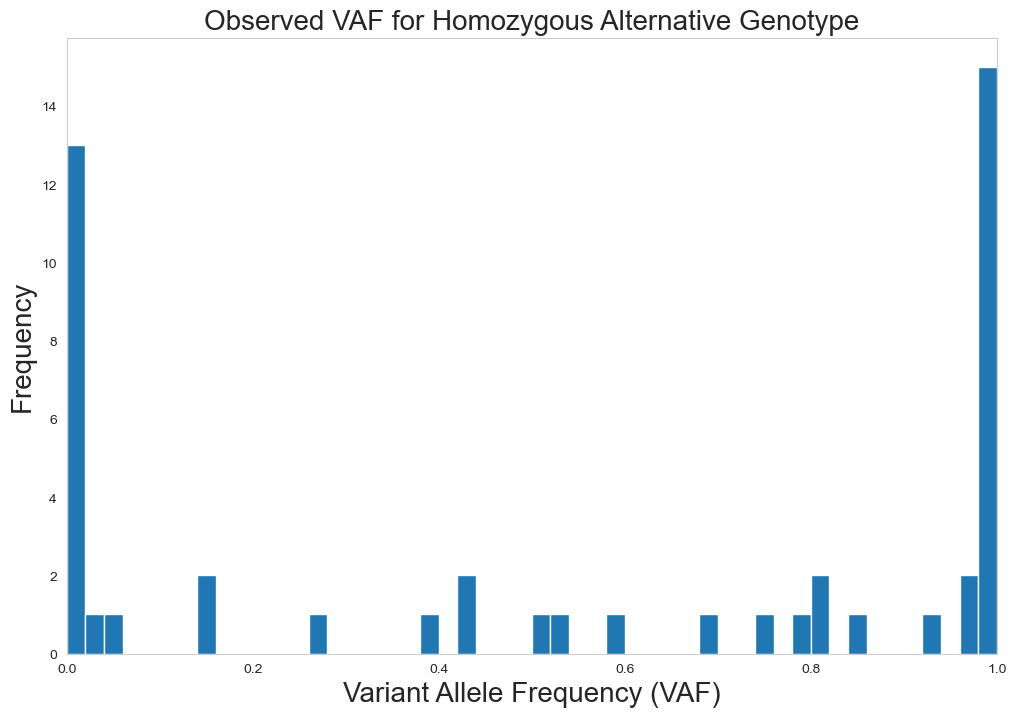

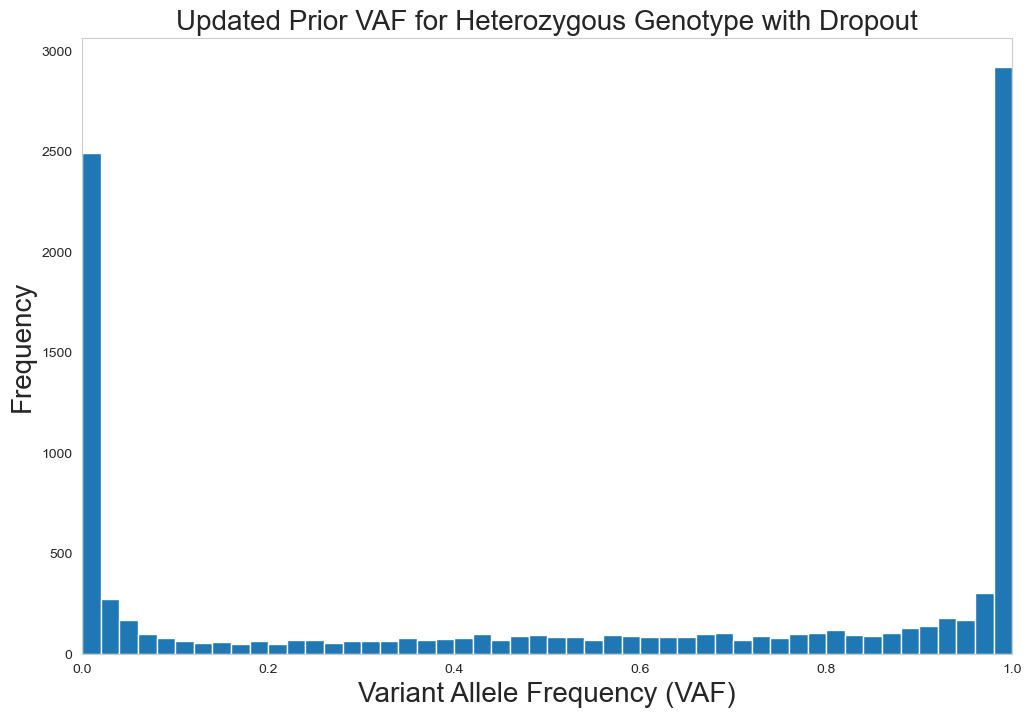

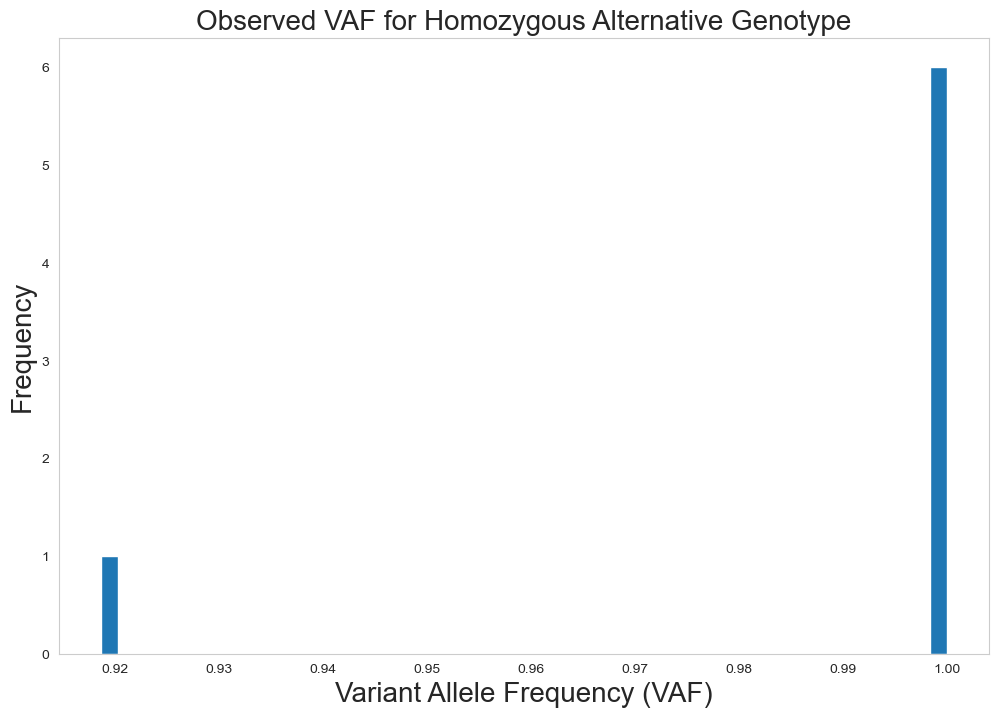

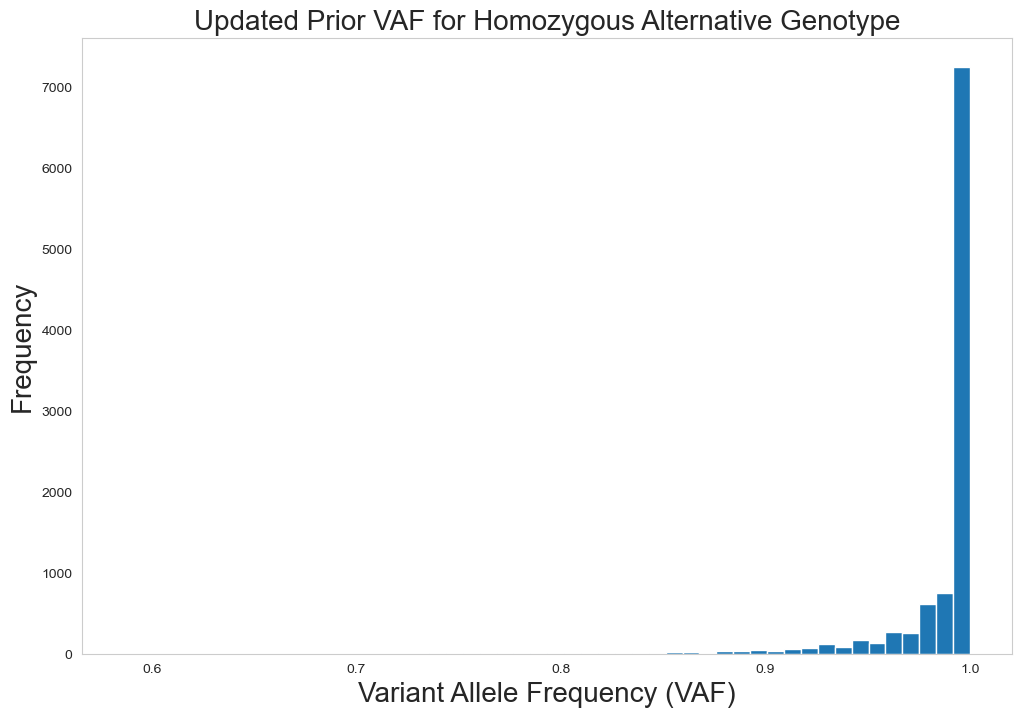

In [298]:
N = 300                 # Read depth
num_simulations = 10000 # Number of simulations

plt.figure(figsize=(12, 8))
indices = np.where(np.array(genotypes) == "Aa")[0]
plt.hist((k_obs_nonzero/N_nonzero)[indices], bins=50)
plt.title("Observed VAF for Homozygous Alternative Genotype", fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xlim([0, 1])
plt.grid(False)
plt.show()

vaf_counts = simulate_vaf_counts(alpha_h, beta_h, dropout_prob, dropout_direction_prob, N, num_simulations, error_rate, overdispersion)

plt.figure(figsize=(12, 8))
plt.hist(vaf_counts, bins=50)
plt.title("Updated Prior VAF for Heterozygous Genotype with Dropout",  fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.xlim([0, 1])
plt.ylabel("Frequency", fontsize=20)
plt.grid(False)

plt.show()

plt.figure(figsize=(12, 8))
indices = np.where(np.array(genotypes) == "AA")[0]
plt.hist((k_obs_nonzero/N_nonzero)[indices], bins=50)
plt.title("Observed VAF for Homozygous Alternative Genotype", fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.grid(False)
plt.show()

alpha = (1-error_rate) * overdispersion
beta = overdispersion - alpha

# Generate simulated data for VAF using Beta-Binomial
simulated_vaf = betabinom.rvs(N, alpha, beta, size=10000) / N  # Scale by N to get VAFs

plt.figure(figsize=(12, 8))
plt.hist(simulated_vaf, bins=50)
plt.title("Updated Prior VAF for Homozygous Alternative Genotype", fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.grid(False)
plt.show()